In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pywt

from bokeh.io import output_notebook, show
from bokeh.plotting import figure

In [14]:
output_notebook()

Loading BokehJS ...

# Import data

In [2]:
data = pd.read_csv('SP-280-Leste.csv', sep=',',header=None)
data.head()

,0,1,2,3
0,1,01/09/2011 00:00,37,89.0
1,2,01/09/2011 00:05,48,82.0
2,3,01/09/2011 00:10,26,85.0
3,4,01/09/2011 00:15,47,81.0
4,5,01/09/2011 00:20,52,82.0


In [3]:
data = data.drop(columns=0)
data.head()

,1,2,3
0,01/09/2011 00:00,37,89.0
1,01/09/2011 00:05,48,82.0
2,01/09/2011 00:10,26,85.0
3,01/09/2011 00:15,47,81.0
4,01/09/2011 00:20,52,82.0


## Organize the dataset

In [4]:
# Rename columns
data = data.rename(columns={0:"ID", 1:"Data-Hora",2:"Fluxo[veic/h.faixa]", 3:"Velocidade[km/h]" })

# Calculate flow rate
data["Fluxo[veic/h.faixa]"] = data["Fluxo[veic/h.faixa]"] * 60 / 5 / 2

# Convert to_datetime
data['Data-Hora'] = pd.to_datetime(data['Data-Hora'], format='%d/%m/%Y %H:%M')

data.head()

,Data-Hora,Fluxo[veic/h.faixa],Velocidade[km/h]
0,2011-09-01 00:00:00,222.0,89.0
1,2011-09-01 00:05:00,288.0,82.0
2,2011-09-01 00:10:00,156.0,85.0
3,2011-09-01 00:15:00,282.0,81.0
4,2011-09-01 00:20:00,312.0,82.0


In [5]:
data.dtypes

Data-Hora              datetime64[ns]
Fluxo[veic/h.faixa]           float64
Velocidade[km/h]              float64
dtype: object

In [6]:
data.shape

(105408, 3)

In [7]:
data.isna().sum()

Data-Hora              0
Fluxo[veic/h.faixa]    0
Velocidade[km/h]       1
dtype: int64

In [8]:
data = data.fillna(0.0)
data.isna().sum()

Data-Hora              0
Fluxo[veic/h.faixa]    0
Velocidade[km/h]       0
dtype: int64

In [9]:
data.head()

,Data-Hora,Fluxo[veic/h.faixa],Velocidade[km/h]
0,2011-09-01 00:00:00,222.0,89.0
1,2011-09-01 00:05:00,288.0,82.0
2,2011-09-01 00:10:00,156.0,85.0
3,2011-09-01 00:15:00,282.0,81.0
4,2011-09-01 00:20:00,312.0,82.0


## Understand DateTime

In [ ]:
data['Data-Hora'].dt.year

# Plotting data

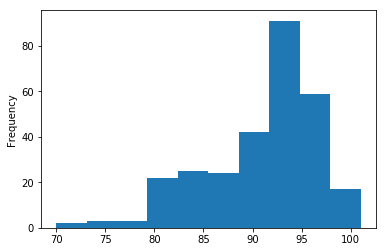

In [10]:
data.loc[data['Data-Hora']<'2011-09-02','Velocidade[km/h]'].plot(kind='hist')

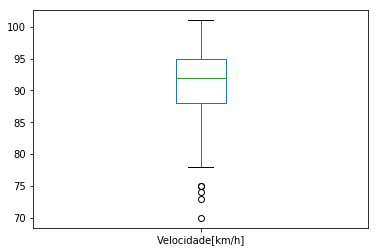

In [11]:
data.loc[data['Data-Hora']<'2011-09-02','Velocidade[km/h]'].plot(kind='box')

## Speed-Flow relationship

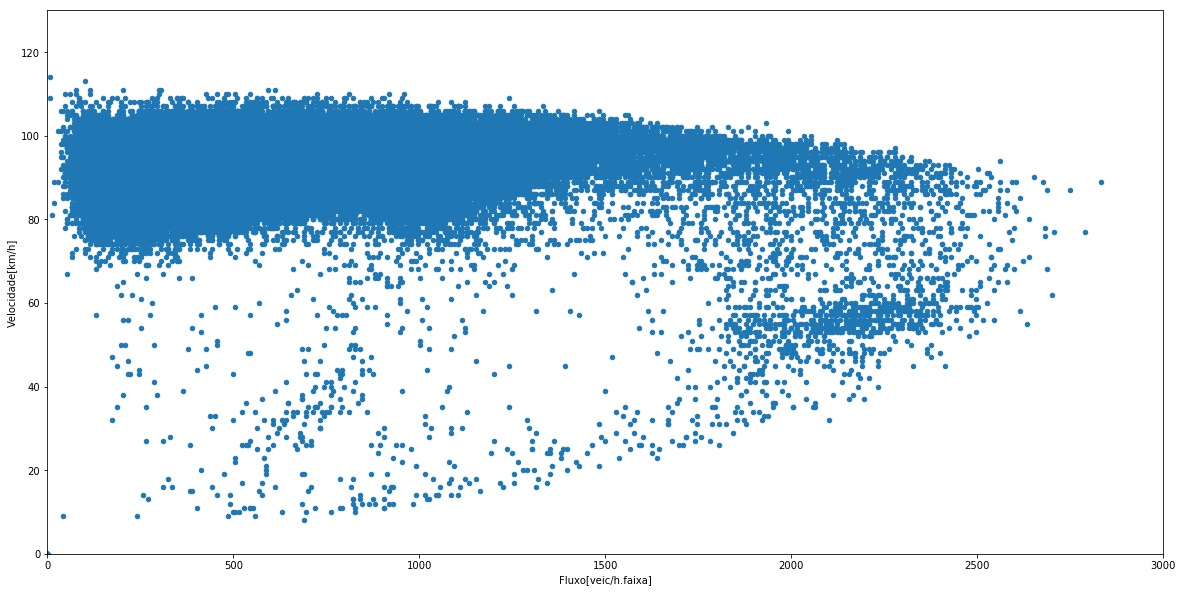

In [12]:
data.plot(x='Fluxo[veic/h.faixa]',
          y='Velocidade[km/h]',
          kind='scatter',
          figsize=(20,10),
         xlim=(0,3000),
         ylim=(0,130))

In [ ]:
# using Bokeh
p = figure(plot_width=800,plot_height=500)
p.circle(
    data['Fluxo[veic/h.faixa]'],
    data['Velocidade[km/h]'],
    size=3)

show(p)

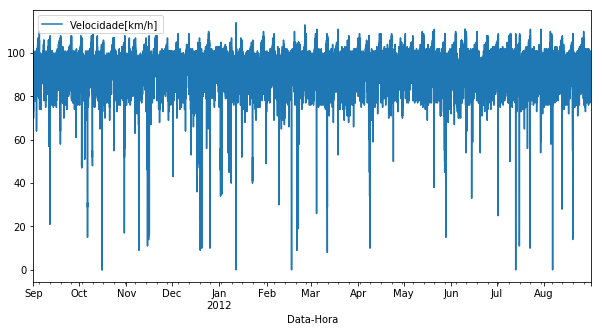

In [21]:
data.plot(x='Data-Hora',
          y='Velocidade[km/h]',
          kind='line',
          figsize=(10,5))

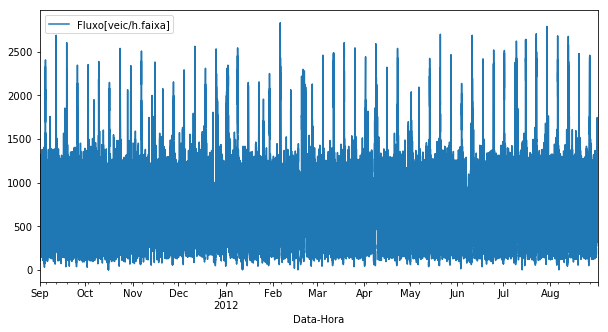

In [22]:
data.plot(x='Data-Hora',
          y='Fluxo[veic/h.faixa]',
          kind='line',
          figsize=(10,5))

In [25]:
# using Bokeh
p = figure(x_axis_type="datetime", plot_height=500, plot_width=800)
p.line(data['Data-Hora'], data['Velocidade[km/h]'])
show(p)

# Wavelet Analysis

## Introduction

In [ ]:
pywt.families()

In [ ]:
t = 5#min
n = 288#data.size

while n>2:
    print(t,' min -> ', n)
    t *= 2
    n /= 2

## Applying in all dataset

In [ ]:
cA, cD = pywt.dwt(data['Velocidade[km/h]'],'haar')

In [ ]:
data['Velocidade[km/h]'].plot()

In [ ]:
plt.plot(cD)

In [ ]:
nlevel = 4
res = pywt.wavedec(data['Velocidade[km/h]'],'haar',level=nlevel)
#res

In [ ]:
for i in range(nlevel+1):
    plt.figure()
    plt.plot(res[i])

In [ ]:
value = res[0].mean()
res[0] = np.where(res[0] < 200, 200, res[0])
res[0] = np.where(res[0] < -200, -200, res[0])

In [ ]:
signal = pywt.waverec(res,'haar')

plt.figure(figsize = (20,10))
plt.scatter(data['Fluxo[veic/h.faixa]'], data['Velocidade[km/h]'], color='grey')
plt.scatter(data['Fluxo[veic/h.faixa]'], signal, s=3, color='red')

## Applying in each day

In [ ]:
db = data[0:288]

# Plot Speed-Time and Flow-Time
fig = plt.figure()
plt.plot(db["Data-Hora"],db['Fluxo[veic/h.faixa]'])

fig = plt.figure()
plt.plot(db["Data-Hora"],db['Velocidade[km/h]'])

In [ ]:
cA, cD = pywt.dwt(db['Fluxo[veic/h.faixa]'] ,'haar')
plt.plot(cA)
plt.figure()
plt.plot(cD,color='orange')

In [ ]:
cA, cD = pywt.dwt(db['Velocidade[km/h]'] ,'haar')
plt.plot(cA)
plt.figure()
plt.plot(cD,color='orange')

In [ ]:
def scatterHist(x,y):
    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005


    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]

    # start with a rectangular Figure
    plt.figure(figsize=(8, 8))

    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)

    # the scatter plot:
    ax_scatter.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 20
    limx = np.ceil(np.abs(x).max() / binwidth) * binwidth
    limy = np.ceil(np.abs(y).max() / binwidth) * binwidth
    ax_scatter.set_xlim((0, limx))
    ax_scatter.set_ylim((0, limy))

    binsx = np.arange(0, limx + binwidth, binwidth)
    binsy = np.arange(0, limy + binwidth, binwidth)
    ax_histx.hist(x, bins=binsx)
    ax_histy.hist(y, bins=binsy, orientation='horizontal')

    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())

    plt.show()

In [ ]:
scatterHist(data['Fluxo[veic/h.faixa]'], data['Velocidade[km/h]'])